# Currents in the Haldane model

In [5]:
import numpy as np
from scipy.linalg import eigh
from scipy.optimize import root
import matplotlib.pyplot as plt
# For Voronoi plots
from scipy.spatial import Voronoi
import matplotlib as mpl
import matplotlib.cm as cm

from lattice import OpenLattice, SquareLattice
from hamiltonian import OpenHamiltonian
from plot_lattice import plot_voronoi

## Hamiltonian parameters

Hamiltonian:

$$ H = \sum_{ij} A_{ij}\ c^\dagger_i c_j = t_1 \sum_{\langle ij\rangle} c^\dagger_i c_j + t_2 \sum_{\langle\langle ij\rangle\rangle} e^{i\phi_{ij}} c^\dagger_i c_j $$

In [6]:
# Lattice sizes
Nx = Ny = 25
N = 300

# Haldane Hamiltonian's parameters
t1 = 1
t2 = 1
dphi = 0.5
lattice_imbalance = 0

# Harmonica trap strength
trap_potential = 1/20

lattice = OpenLattice(Nx, Ny)
hopping_params = (t1, t2, dphi)
hoppings_type = 'haldane'
ham = OpenHamiltonian(lattice, hopping_params, hoppings_type,
                      trap_potential, lattice_imbalance)

print(f'Number of sites = {lattice.L}')
print(f'Number of particles = {N}')

Number of sites = 1250
Number of particles = 300


## Hamiltonian diagonalization

$$ H = \sum_{ij} c^\dagger_i A_{ij} c_j = \sum_{ij} c^\dagger_i V_{im} D_m V^*_{jm} c_j = \sum_m f^\dagger_m D_m f_m $$

Therefore the new basis is

$$f^\dagger_m = \sum_i V_{im} c^\dagger_i,\quad f_m = \sum_i V^*_{im} c_i $$

The occupation numbers of these new basis at a finite temperature $\beta$ are given by the Fermi-Dirac distribution

$$ \langle f^\dagger_m f_n \rangle = \delta_{mn}\frac{1}{1+e^{\beta(E_m - \mu)}}$$

with $E_m$ the eigenenergy of $f^\dagger_m$ and $\mu$ the chemical potential, which we must adjust so that the number of particles equals a chose one

$$ \langle N(\mu)\rangle = \sum_m \langle f^\dagger_m f_m \rangle = \sum_m \frac{1}{1+e^{\beta(E_m - \mu)}}$$

The expected values of the two-body operators at finite temperature are

$$ \langle c^\dagger_i c_j\rangle = \sum_{mn} V^*_{im} V_{jn} \langle f^\dagger_m f_n\rangle = \sum_m V^*_{im} V_{jm} \frac{1}{1+e^{\beta (E_m - \mu)}}$$

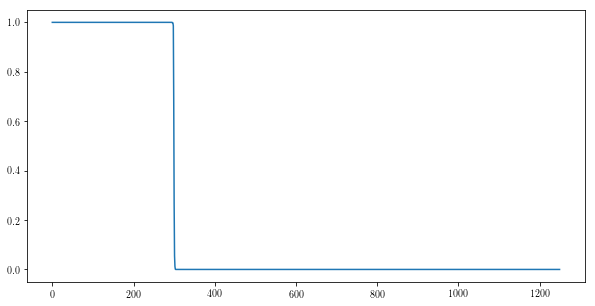

In [14]:
w, v = eigh(ham.A)

# Temperature
β = 100

# Computation of the chemical potential
def particle_number_with_mu(μ, w, β, N):
    """Particle number with a given chemical potential.
    
    Args:
        μ (float): chemical potential.
        w (1darray of floats): single-particle Hamiltonian spectrum.
        β (float): inverse temperature.
        N (int or float): expected number of particles.
        
    Returns:
        (float): deviation of the particle number with μ with respect
            to N.
            
    """
    return np.sum(1/(1+np.exp(β*(w-μ)))) - N

μ_0 = (w[N-1] + w[N])/2
sol = root(particle_number_with_mu, μ_0, args=(w, β, N))
μ = sol.x

# Fermi-Dirac distribution
fd_dist = 1/(1 + np.exp(β*(w-μ)))

# Plot the Fermi-Dirac distribution
plt.figure(figsize=(10, 5))
plt.plot(fd_dist)
plt.show()

# Expected values
expected = np.einsum('im,jm,m->ij', np.conj(v), v, fd_dist)

## Occupation numbers


Maximum occupation: 0.9995447031822723


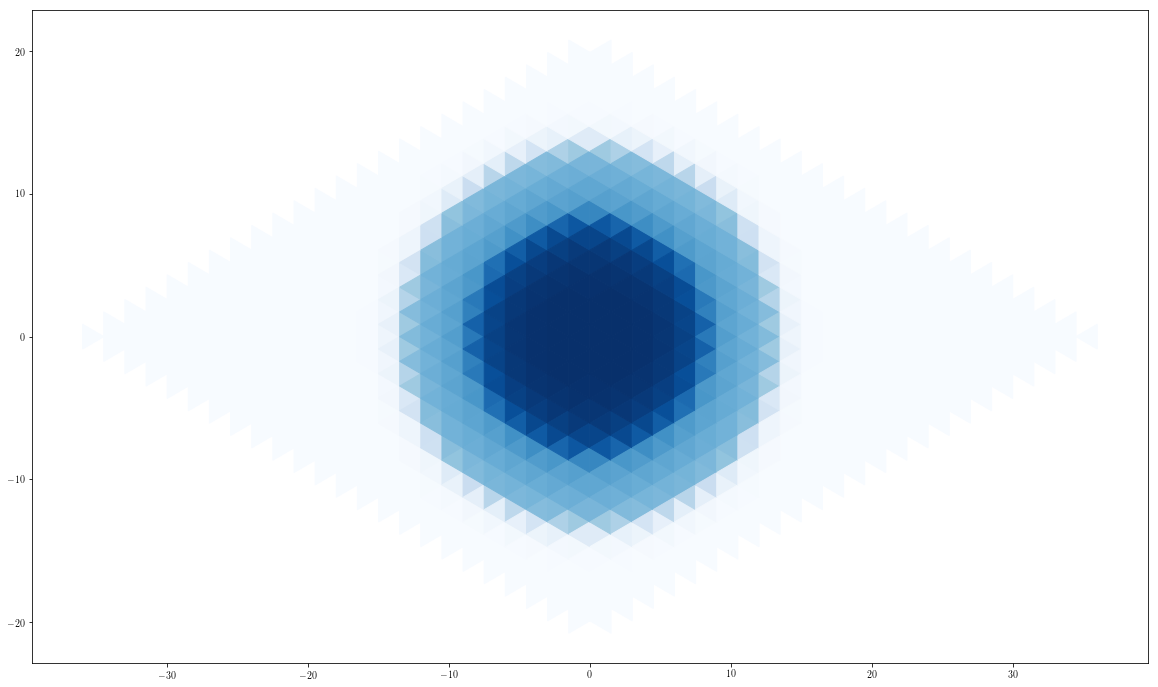

In [10]:
occupations = np.real(np.diag(expected))
plot_voronoi(lattice, occupations)

print('Maximum occupation: {}'.format(np.max(occupations)))

## Currents

The time variation of the occupation number is
$$ \langle\frac{d}{dt}n_i\rangle = -i\langle\left[n_i,\ H\right]\rangle = -i\left(\sum_j A_{ij}\ \langle c^\dagger_i c_j\rangle - A_{ji}\ \langle c^\dagger_j c_i\rangle\right) = 2\sum_j \textit{Im} \left[A_{ij}\ \langle c^\dagger_i c_j\rangle\right]$$

The current flowing from site $i$ to site $j$ can be defined as

$$ J_{ij} = 2\ \textit{Im}\left[ A_{ij}\ \langle c^\dagger_i c_j\rangle\right] $$

The current conservation law is thus conserved as

$$ \langle\frac{d}{dt}n_i\rangle = \sum_j J_{ij} $$

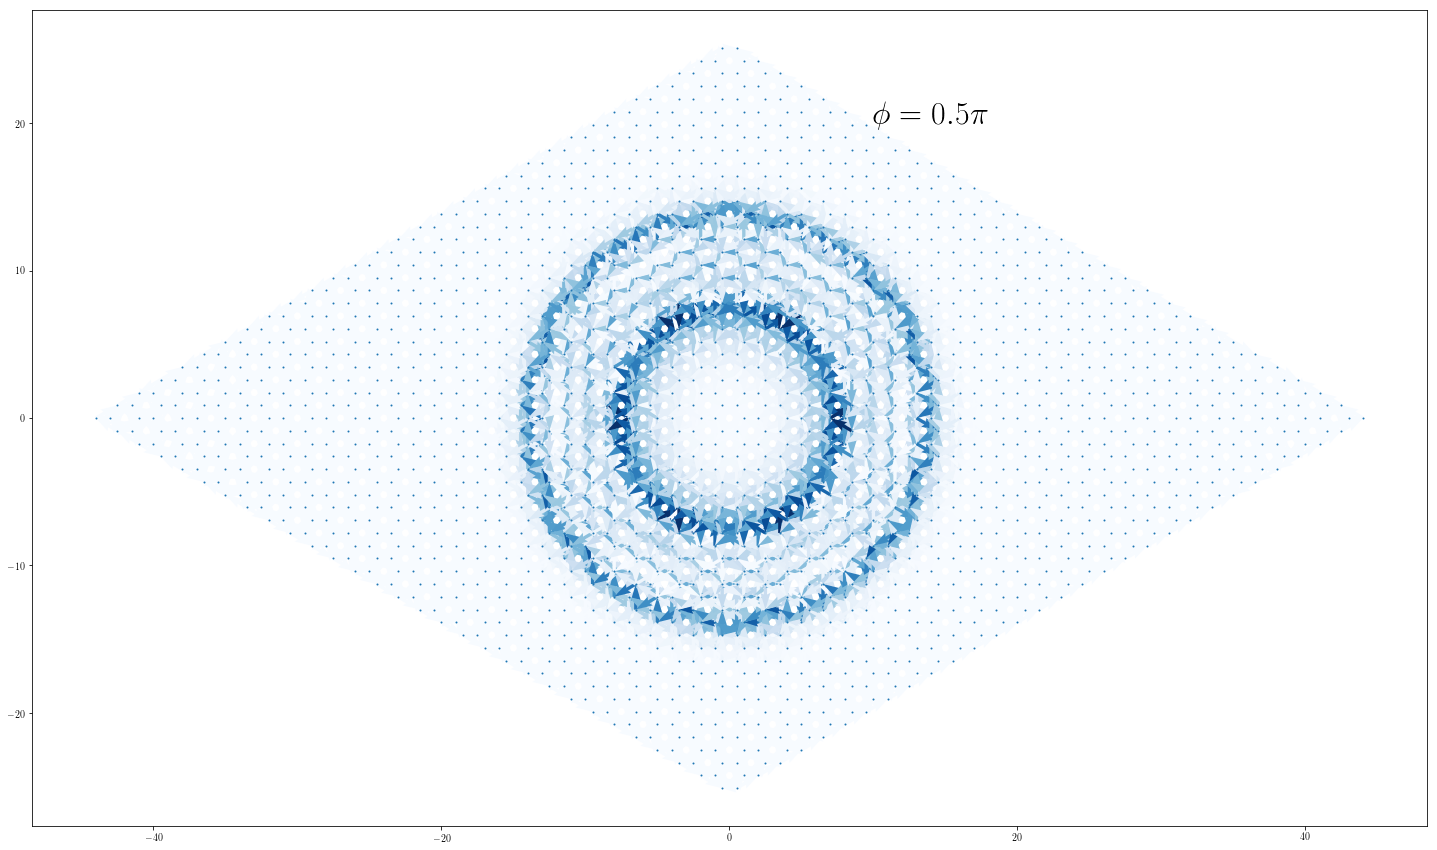

In [5]:
currents = 2*np.imag(ham.A*expected)

ij = np.nonzero(np.logical_and(currents > 0, np.abs(currents) > 1e-8))
ij = np.nonzero(currents > 0)

x = lattice.xy_coords[ij[0], 0]
y = lattice.xy_coords[ij[0], 1]
u = lattice.xy_coords[ij[1], 0] - x
v = lattice.xy_coords[ij[1], 1] - y
c = currents[ij]

fig = plt.figure(figsize=(25, 15))
plt.quiver(x, y, u, v, c, cmap='Blues', scale=1, units='xy', angles='xy', scale_units='xy')
plt.scatter(lattice.xy_coords[:, 0], lattice.xy_coords[:, 1], s=1)
plt.text(10, 20, r'$\phi = {}\pi$'.format(dphi), fontsize=32)
# plt.savefig('./images/two_point_currents_phi_0.pdf')
plt.show()

### Occupations and currents

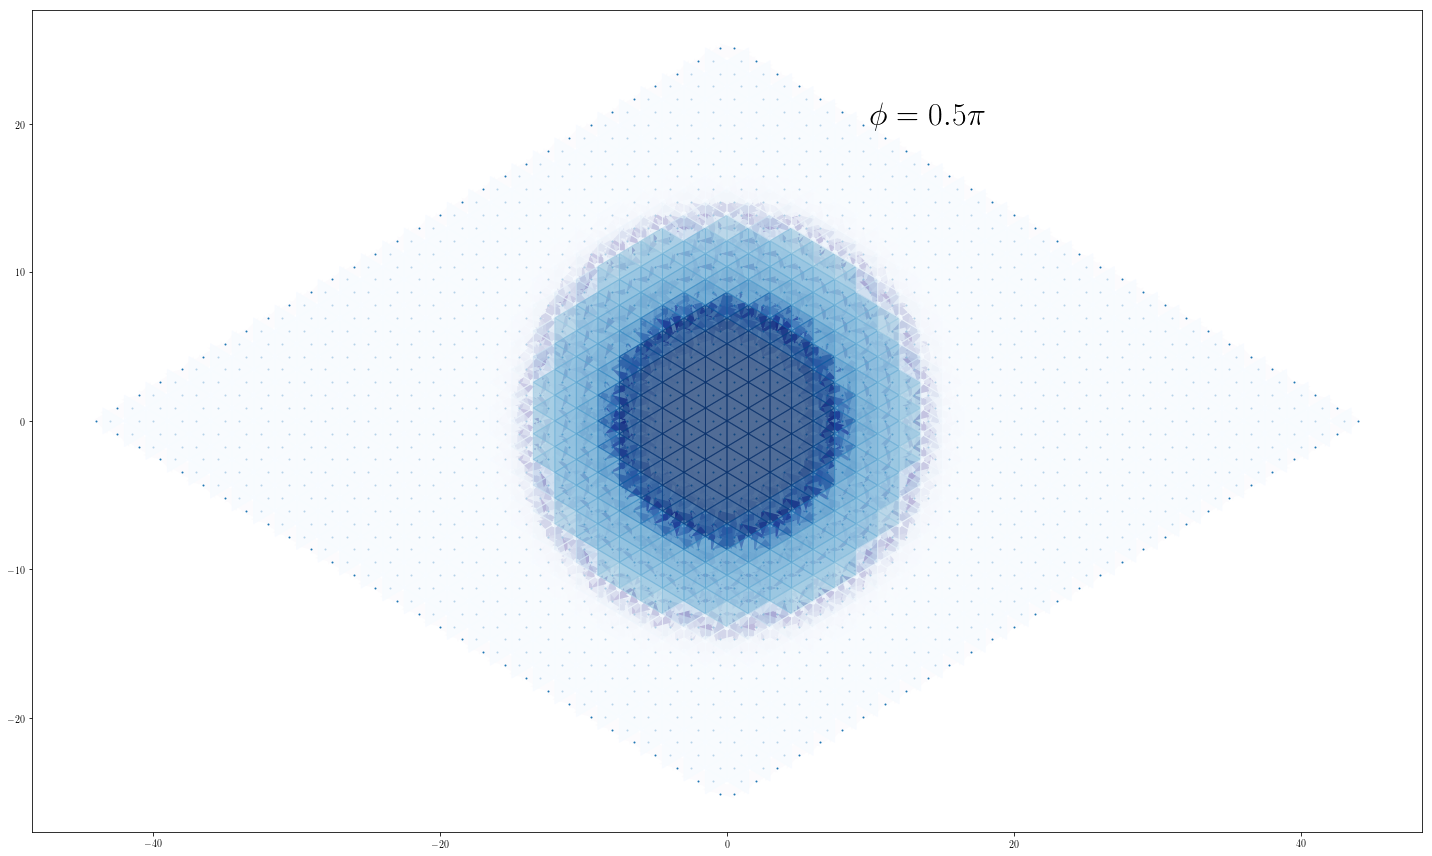

In [6]:
plt.figure(figsize=(20, 12))

vor = Voronoi(lattice.xy_coords)
data = occupations
norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data),
                            clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
for r in range(len(vor.point_region)):
    region = vor.regions[vor.point_region[r]]
    if not np.any(np.isclose(-1, region)):
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), color=mapper.to_rgba(data[r]), alpha=0.7, edgecolor=None)

plt.quiver(x, y, u, v, c, cmap='Purples', scale=1, units='xy', angles='xy', scale_units='xy')
plt.scatter(lattice.xy_coords[:, 0], lattice.xy_coords[:, 1], s=1)
plt.text(10, 20, r'$\phi = {}\pi$'.format(dphi), fontsize=32)

plt.tight_layout()
# plt.savefig('images/occupations_and_currents_dphi_0p5.pdf')
plt.show()

### Chiral currents

To better observe the currents in the system we should plot total currents going through closed paths, like the closed triangle connecting all sites of a particular sublattice in one hexagon, both triangles, or both triangles and the current going through the edges of the hexagon. 

#### Coordinates of every closed hexagon in the lattice

In [14]:
# Relative coordinates of a single hexagon with respect to the lower left point.
hex_coords = np.array([[0, 0, 0], [-1, 0, 1], [-1, 1, 0],
                       [-1, 1, 1], [0, 1, 0], [0, 0, 1]], np.int64)

# Array with the indices of every point in every hexagon.
hexagons = np.zeros((lattice.L//2, 6), np.int64)
for i in range(0, lattice.L, 2):
    if (lattice.lat_coords[i][0] == 0) or (lattice.lat_coords[i][1] == lattice.Ny-1):
        continue
    i_coord = lattice.lat_coords[i]
    # Indices of the points that define an hexagon. If some index is -1, the hexagon is open.
    hex_ix = np.zeros(6, np.int64)
    for j in range(6):
        hexagons[i//2, j] = lattice.position_to_index(i_coord + hex_coords[j])

#### All currents

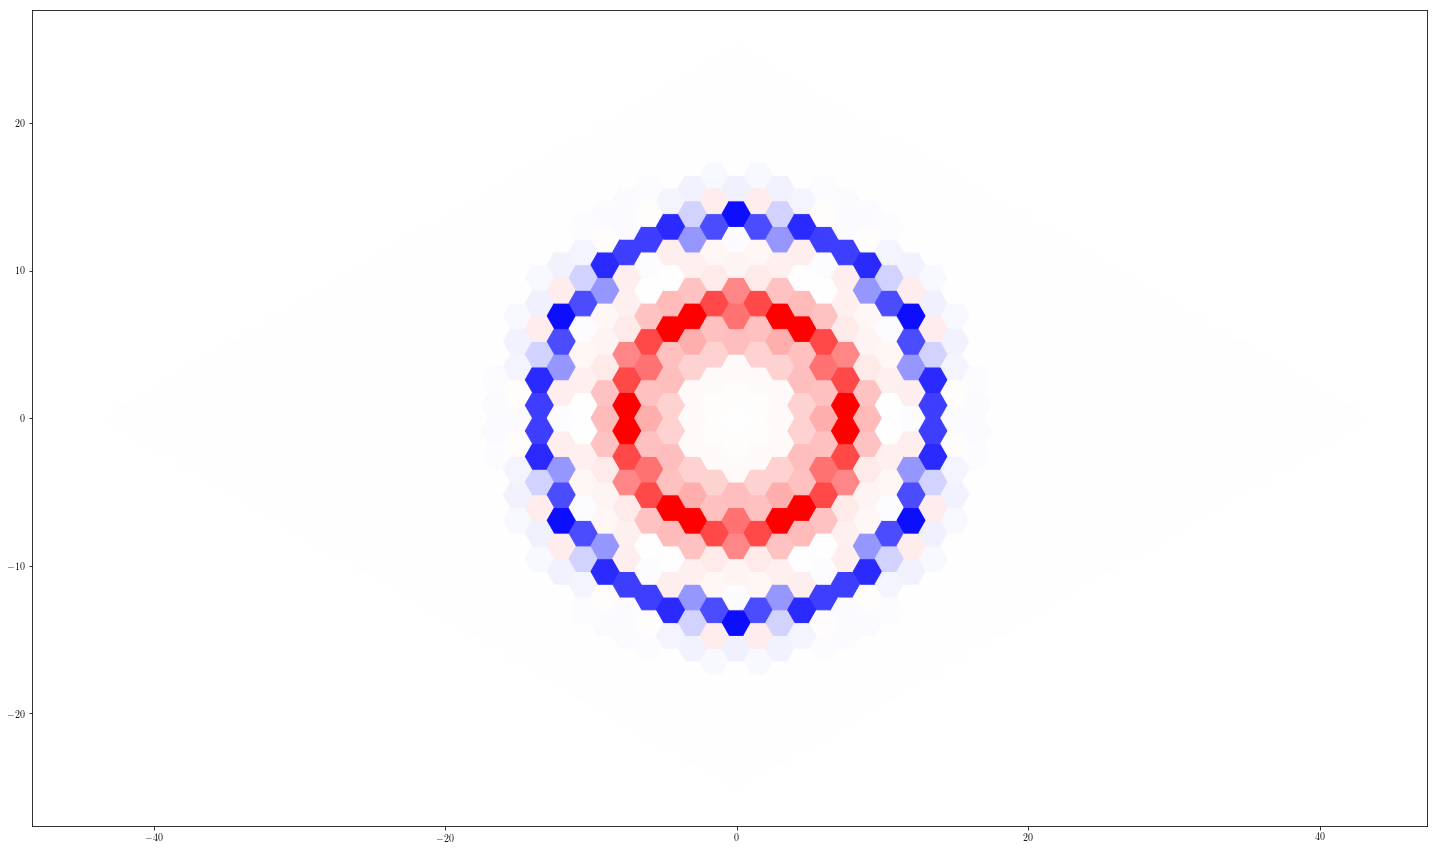

In [31]:
# Circular currents
circular_currents = np.zeros(hexagons.shape[0], np.float64)
for i in range(hexagons.shape[0]):
    for j in range(6):
        # First neighbor currents.
        circular_currents[i] += currents[hexagons[i, (j+1)%6], hexagons[i, j]]
    for j in range(3):
        # Sublattice A second neighbor currents.
        circular_currents[i] += currents[hexagons[i, (2*j+2)%6], hexagons[i, 2*j]]
        # Sublattice B second negihbor currents.
        circular_currents[i] += currents[hexagons[i, (2*j+3)%6], hexagons[i, 2*j+1]]

data = circular_currents
max_abs_data = np.max(np.abs(data))
norm = mpl.colors.Normalize(vmin=-max_abs_data, vmax=max_abs_data,
                            clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
        
plt.figure(figsize=(25, 15))
for i in range(hexagons.shape[0]):
    plt.fill(lattice.xy_coords[hexagons[i], 0], lattice.xy_coords[hexagons[i], 1],
             color=mapper.to_rgba(data[i]))
plt.show()

## Time of flight images

Let's suppose we release the optic trap that simulated the Haldane model. We can consider that the particles will then expand as plane waves without interference between them. Therefore, the momentum distribution after we have released them from the trap will be

$$ \langle \psi^\dagger (\vec{k})\ \psi (\vec{k})\rangle \sim \sum_{ij} e^{i\vec{k}(\vec{x}_i - \vec{x}_j)} \langle a^\dagger_i a_j \rangle $$

This computation can be numerically done with ease if we first define a matrix

$$ U_{ki} = e^{-i\vec{k}\vec{x}_i}$$

Therefore

$$ \langle \psi^\dagger (\vec{k})\ \psi (\vec{k})\rangle \sim \sum_{ij} U_{ki} \langle a^\dagger_i a_j \rangle U^*_{kj} $$

### Brillouin zone

We must define the vectors $\vec{k}$, which are those of the first Brillouin zone. This zone is the region expanded by the vectors $\vec{a}_x$ and $\vec{a}_y$, which we cut into a grid with $M_x\times M_y$ points. The Brillouin vectors satisfy the relations: $\vec{v}_i \cdot \vec{a}_j = 2\pi\delta_{ij}$, with $\vec{v}_i$ the displacement vectors inside a sublattice in real space.

### Releasing both sublattices at once

In this case $U_{ki}$ goes over all positions of the lattice.

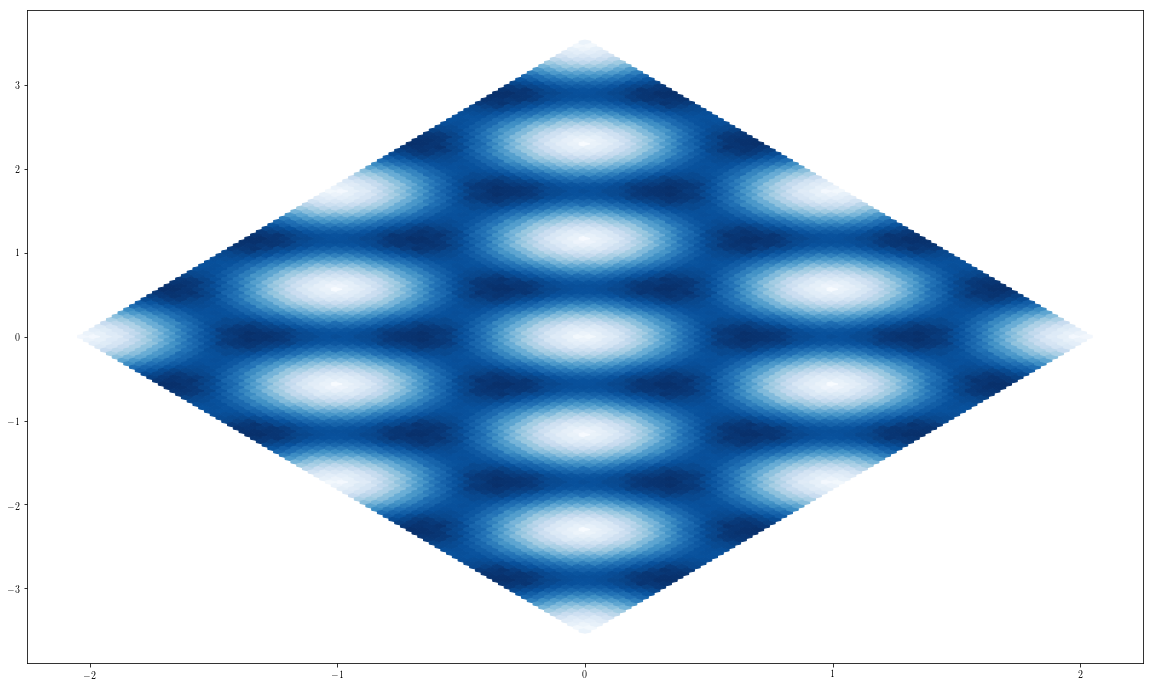

In [33]:
# Brillouin zone grid dimensions
Mx = 3*lattice.Nx
My = 3*lattice.Ny
brillouin = SquareLattice(Mx, My)

# U matrix
kx = brillouin.xy_coords[:, 0]
ky = brillouin.xy_coords[:, 1]
xi = lattice.xy_coords[:, 0]
yi = lattice.xy_coords[:, 1]
U = np.exp(-1j*2*np.pi*(np.outer(kx, xi) + np.outer(ky, yi)))/(Mx*My)

# Expected values in momentum space
tof_expected = np.real(np.einsum('ki,ij,kj->k', U, expected, np.conj(U)))
plot_voronoi(brillouin, tof_expected)

### Releasing only sublattice A

In this case $U_{ki}$ goes over all positions of sublattice A.

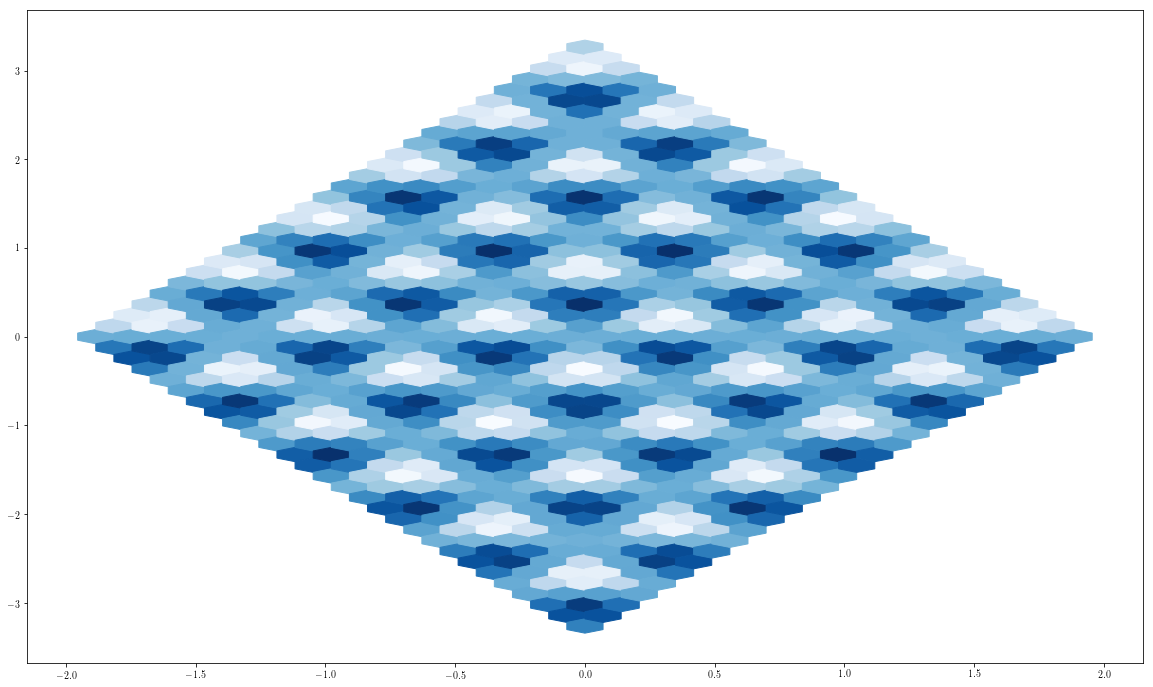

In [12]:
Ua = np.copy(U)
Ua[:, np.arange(0, lattice.L, 2)] = 0

# Expected values in momentum space
tof_expected_a = np.real(np.einsum('ki,ij,kj->k', Ua, expected, np.conj(Ua)))
plot_voronoi(brillouin, tof_expected_a)

### Releasing only sublattice B

In this case $U_{ki}$ goes over all positions of sublattice B.

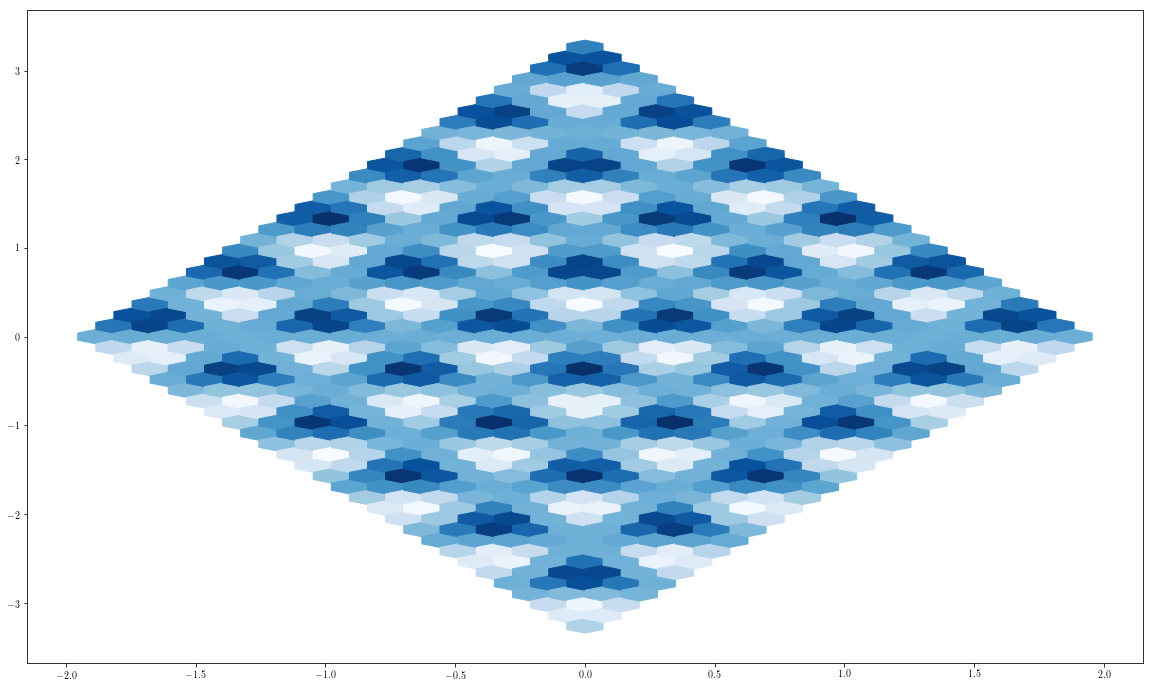

In [13]:
Ub = np.copy(U)
Ub[:, np.arange(1, lattice.L, 2)] = 0

# Expected values in momentum space
tof_expected_b = np.real(np.einsum('ki,ij,kj->k', Ub, expected, np.conj(Ub)))
plot_voronoi(brillouin, tof_expected_b)